# Case 3: Predicting with text and ratings


# LSTM


## Data processing


### Load libraries


In [1]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
from wordcloud import WordCloud

# keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.regularizers import l1, l2
from keras import regularizers
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score

# natural language processing toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop/IT1244/Project


### Importing and Data cleaning


Functions for importing and cleaning the data


In [2]:
def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: List of clean words
    '''
    # Remove HTML Tags and stop words
    stop_words = set(stopwords.words("english"))
    clean = BeautifulSoup(TEXT, "html.parser").get_text()
    clean = re.sub("[^a-zA-Z0-9]", " ", clean)
    word_tokens = clean.lower().split()
    le = WordNetLemmatizer()
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    return word_tokens


def loadAllData(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "rating", "sentiment", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID, posRating = int(posDetails[0]), int(posDetails[1])
        # Add data into the Dataframe
        row = {"id": posID, "rating": posRating,
               "sentiment": 1, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID, negRating = int(negDetails[0]) + 25000, int(negDetails[1])
        row = {"id": negID, "rating": negRating,
               "sentiment": 0, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

In [4]:
# Load data (approx. 30s)
dataframe = loadAllData()
dataframe.head(5)

Processing Positive Reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

Processing Negative Reviews: 100%|██████████| 25000/25000 [00:15<00:00, 1653.29it/s]


,id,rating,sentiment,text
0,20935,9,1,"[watched, return, lonesome, dove, good, seen, ..."
1,12390,8,1,"[movie, looked, like, classic, cheesy, slasher..."
2,9820,8,1,"[jay, chou, play, orphan, raised, kung, fu, sc..."
3,883,7,1,"[ooverall, movie, fairly, good, good, action, ..."
4,9063,8,1,"[movie, fun, watch, liked, dave, kevin, klein,..."


### Split training, validation and testing data sets


To train the model, an equal number of positive and negative classified text is split into the training set (70%), the validation set (15%) and the testing set (15%)


In [5]:
# Divide positive and negative reviews into test, train and validation sets
df_pos = dataframe[dataframe['rating'] >= 5]
df_neg = dataframe[dataframe['rating'] < 5]
print(f'Shape of df_pos is {df_pos.shape}')
print(f'Shape of df_neg is {df_neg.shape}\n')
# Shuffle the data into its group
df_pos = shuffle(df_pos, random_state=321)
df_neg = shuffle(df_neg, random_state=123)
# Training(0.7), test(0.15) and validation(0.15) data for the pos set
x_pos = df_pos['text']
y_pos = df_pos['sentiment']
x_train_pos, x_test_temp, y_train_pos, y_test_temp = train_test_split(
    x_pos, y_pos, test_size=0.3, random_state=99)
x_test_pos, x_valid_pos, y_test_pos, y_valid_pos = train_test_split(
    x_test_temp, y_test_temp, test_size=0.5, random_state=99)
# Training(0.7), test(0.15) and validation(0.15) data for the neg set
x_neg = df_neg['text']
y_neg = df_neg['sentiment']
x_train_neg, x_test_temp, y_train_neg, y_test_temp = train_test_split(
    x_neg, y_neg, test_size=0.3, random_state=99)
x_test_neg, x_valid_neg, y_test_neg, y_valid_neg = train_test_split(
    x_test_temp, y_test_temp, test_size=0.5, random_state=99)
# Join the pos and neg sets together and shuffle them
x_train = pd.concat([x_train_pos, x_train_neg], axis=0)
x_test = pd.concat([x_test_pos, x_test_neg], axis=0)
x_valid = pd.concat([x_valid_pos, x_valid_neg], axis=0)
y_train = pd.concat([y_train_pos, y_train_neg], axis=0)
y_test = pd.concat([y_test_pos, y_test_neg], axis=0)
y_valid = pd.concat([y_valid_pos, y_valid_neg], axis=0)
# Check if data is correctly split
print(f'Shape of x_train is {x_train.shape}')
print(f'Shape of x_test is {x_test.shape}')
print(f'Shape of x_valid is {x_valid.shape}\n')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')
print(f'Shape of y_valid is {y_valid.shape}')

Shape of df_pos is (25000, 4)
Shape of df_neg is (25000, 4)

Shape of x_train is (35000,)
Shape of x_test is (7500,)
Shape of x_valid is (7500,)

Shape of y_train is (35000,)
Shape of y_test is (7500,)
Shape of y_valid is (7500,)


The texts are passed into a tokenizer which facilitates the transformation of unstructured text data into a numbers which each represents a unique word.


In [6]:
# Obtain the list of vocabulary size from the training dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.tolist())
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
index_word = {i: word for word, i in word_index.items()}
index_word[0] = ""
print(f'Vocab size: {vocab_size}')

# convert words into sequences to input into the model
x_train_seq = tokenizer.texts_to_sequences(x_train.tolist())
x_test_seq = tokenizer.texts_to_sequences(x_test.tolist())
x_valid_seq = tokenizer.texts_to_sequences(x_valid.tolist())

# convert results y into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

# Pad sequences to make them uniform in length
max_seq_len = max(len(x) for x in x_train.tolist())
print(f'Max sequence length: {max_seq_len}')
x_train_padded = pad_sequences(x_train_seq, maxlen=max_seq_len, padding='post')
x_test_padded = pad_sequences(
    x_test_seq, maxlen=max_seq_len, padding='post')
x_valid_padded = pad_sequences(
    x_valid_seq, maxlen=max_seq_len, padding='post')

Vocab size: 78676
Max sequence length: 1416


## Model


### Hyperparameter tuning using randomised search


To identify the optimum hyperparameters to be used for the neural network, hyperparameter random search is used which is a method of exploring the hyperparameter space by randomly selecting combinations of hyperparameter values and evaluating their performance on a validation dataset.


In [30]:
history = pd.read_excel("history.xlsx")
history.head(5)

,epoch,loss,accuracy,val_loss,val_accuracy,hidden_units,embeddings,batch_size,dropout,activation,l1,l2
0,0,2.418565,0.711829,0.584250,0.822933,16,100,64,0.5,sigmoid,0.01,0.0
1,1,0.557358,0.822229,0.643249,0.799733,16,100,64,0.5,sigmoid,0.01,0.0
2,2,0.478398,0.867571,0.481155,0.850000,16,100,64,0.5,sigmoid,0.01,0.0
3,3,0.384289,0.915000,0.455849,0.874267,16,100,64,0.5,sigmoid,0.01,0.0
4,4,0.327513,0.938943,0.452592,0.884533,16,100,64,0.5,sigmoid,0.01,0.0


In [31]:
history_sorted = history.sort_values(
    by=['val_loss', 'val_accuracy'], ascending=[True, False])
history_sorted.head(5)

,epoch,loss,accuracy,val_loss,val_accuracy,hidden_units,embeddings,batch_size,dropout,activation,l1,l2
42,2,0.249534,0.916314,0.314280,0.878400,16,100,128,0.5,sigmoid,0.000,0.00
43,3,0.168944,0.949257,0.331690,0.878400,16,100,128,0.5,sigmoid,0.000,0.00
41,1,0.361438,0.861629,0.335778,0.867867,16,100,128,0.5,sigmoid,0.000,0.00
24,1,0.440023,0.855629,0.365340,0.875600,16,100,64,0.5,sigmoid,0.000,0.01
36,2,0.297021,0.935829,0.392215,0.881733,16,100,64,0.5,sigmoid,0.001,0.00


### Train word embeddings (Word2Vec)


In our models, we use a pre-trained set of word embeddings from Word2Vec to speed up the training process. </br>
Additionally, we adopt a single hidden-layer neural network to avoid long training time due to a large dataset.


In [7]:
embedding_dim = 100

In [8]:
# Train Word2Vec model (approx. 20s)
w2v = Word2Vec(sentences=dataframe["text"], vector_size=embedding_dim,
               window=5, min_count=1, workers=4, seed=99)

In [9]:
vocab = w2v.wv.index_to_key
max_vocab_length = len(vocab)
print("The total number of vocabs are: ", max_vocab_length)

The total number of vocabs are:  91731


In [10]:
max_seq_len = 0
for i in dataframe["text"]:
    if max_seq_len < len(i):
        max_seq_len = len(i)
print("The max sequence length is: ", max_seq_len)

The max sequence length is:  1416


convert text sequences into an embedded matrix


In [11]:
# convert word embeddings into a dictionary key-value pair
w2v_dict = {}
for word in vocab:
    w2v_dict[word] = w2v.wv.get_vector(word)
print("The number of key-value pairs is: ", len(w2v_dict))

The number of key-value pairs is:  91731


In [12]:
# convert mapping of words (tokenization) into word embeddings (word2vec)
embed_matrix = np.zeros(shape=(max_vocab_length, embedding_dim))
for word, i in tokenizer.word_index.items():
    embed_vector = w2v_dict.get(word)
    if embed_vector is not None:
        embed_matrix[i] = embed_vector
    # if word is not found then embed_vector corressponding to that vector will stay zero.

### Model training


<ul>
    <li>embedding_dim = 100</li>
    <li>hidden_units = 16</li>
    <li>Dropout = 0.5</li>
    <li>1 Bidirectional LSTM layer</li>
    <li>1 Batch Normalisation layer</li>
</ul>


In [13]:
# Initialize the model
modelOne = Sequential()
hidden_units = 16

# Add an Embedding layer
modelOne.add(Embedding(input_dim=max_vocab_length,
                       output_dim=embedding_dim, input_length=max_seq_len,
                       embeddings_initializer=Constant(embed_matrix)))

# Bidirectional LSTM layer
modelOne.add(Bidirectional(LSTM(units=hidden_units)))
modelOne.add(Dropout(0.5))
modelOne.add(BatchNormalization())

# Add a Dense output layer
modelOne.add(Dense(1, activation='sigmoid'))

# Compile modelOne
modelOne.compile(loss='binary_crossentropy',
                 optimizer='adam', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

modelOne.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1416, 100)         9173100   
                                                                 
 bidirectional (Bidirection  (None, 32)                14976     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 9188237 (35.05 MB)
Trainable params: 91881

In [14]:
# Train the model
historyOne = modelOne.fit(x_train_padded, y_train, epochs=10,
                          batch_size=128, validation_data=(x_valid_padded, y_valid), callbacks=[early_stopping])

Epoch 1/10
274/274 [==============================] - 212s 769ms/step - loss: 0.6066 - accuracy: 0.6740 - val_loss: 0.6285 - val_accuracy: 0.6836
Epoch 2/10
274/274 [==============================] - 210s 766ms/step - loss: 0.4522 - accuracy: 0.8137 - val_loss: 0.4056 - val_accuracy: 0.8272
Epoch 3/10
274/274 [==============================] - 221s 806ms/step - loss: 0.3661 - accuracy: 0.8588 - val_loss: 0.3593 - val_accuracy: 0.8544
Epoch 4/10
274/274 [==============================] - 213s 776ms/step - loss: 0.2880 - accuracy: 0.8968 - val_loss: 0.3489 - val_accuracy: 0.8631
Epoch 5/10
274/274 [==============================] - 207s 754ms/step - loss: 0.2163 - accuracy: 0.9275 - val_loss: 0.3304 - val_accuracy: 0.8776
Epoch 6/10
274/274 [==============================] - 205s 747ms/step - loss: 0.1518 - accuracy: 0.9538 - val_loss: 0.3463 - val_accuracy: 0.8845
Epoch 7/10
274/274 [==============================] - 203s 741ms/step - loss: 0.1044 - accuracy: 0.9697 - val_loss: 0.7520 -

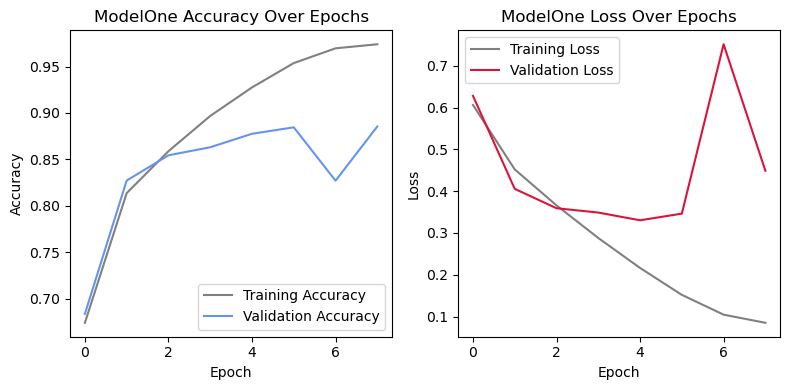

In [15]:
# Plot the accuracy over epochs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(historyOne.history['accuracy'],
         label='Training Accuracy', color='grey')
plt.plot(historyOne.history['val_accuracy'],
         label='Validation Accuracy', color='cornflowerblue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ModelOne Accuracy Over Epochs')
plt.legend()

# Plot the loss over epochs
plt.subplot(1, 2, 2)
plt.plot(historyOne.history['loss'],
         label='Training Loss', color='grey')
plt.plot(historyOne.history['val_loss'],
         label='Validation Loss', color='crimson')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ModelOne Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Analysis of model


In [17]:
# Testing the model and obtain the summary
valid_loss, valid_accuracy = modelOne.evaluate(x_valid_padded, y_valid)
print(f'Validation Accuracy: {valid_accuracy * 100}%')
test_loss, test_accuracy = modelOne.evaluate(x_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy * 100}%')

235/235 [==============================] - 10s 41ms/step - loss: 0.3304 - accuracy: 0.8776
Validation Accuracy: 87.76000142097473%
235/235 [==============================] - 10s 42ms/step - loss: 0.3317 - accuracy: 0.8813
Test Accuracy: 88.13333511352539%


235/235 [==============================] - 10s 41ms/step


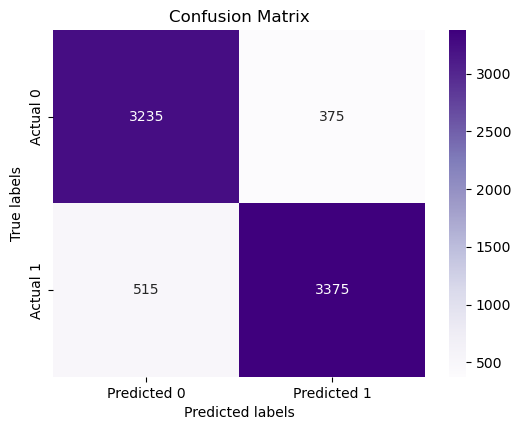

In [191]:
modelOne_pred_actual = modelOne.predict(x_test_padded)
modelOne_pred = [0 if x <= 0.5 else 1 for x in modelOne_pred_actual]

# Plot confusion matrix
conf_matrix = confusion_matrix(modelOne_pred, y_test)
plt.figure(figsize=(6, 4.5))
sns.heatmap(conf_matrix, annot=True, cmap='Purples', fmt='d',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Analysis of incorrect classifications


To understand the features of wrongly classified text, the false negative and positive results were extracted from the dataset.


In [204]:
x_test_complete = pd.DataFrame(
    {"text": x_test, "sentiment": y_test, "pred_sentiment": modelOne_pred, "pred_rating": modelOne_pred_actual.flatten()})
x_test_complete = x_test_complete.merge(
    dataframe, how="left", left_index=True, right_index=True)
x_test_complete.drop(columns=["text_y", "sentiment_y"], inplace=True)
x_test_complete.rename(
    columns={"text_x": 'text', "sentiment_x": "sentiment"}, inplace=True)
x_test_complete.text = [' '.join(x) for x in x_test_complete.text]
print(
    f"{x_test_complete.head(5)}")

                                                    text  sentiment  \
20380  home room came total surprise clue paid big ti...          1   
20290  best movie friendship especially aid infected ...          1   
1356   movie plain silly almost every scene bit humor...          1   
24507  first two jim thompson adaptation released wel...          1   
3590   used enjoy happy ever absolutely hypnotised te...          1   

       pred_sentiment  pred_rating     id  rating  
20380               1     0.973626   8833       8  
20290               1     0.975876  14519      10  
1356                1     0.543161   3264       9  
24507               1     0.964586   9990       9  
3590                1     0.948462  22138      10  


In [205]:
# Dataframe of false negatives
falseNegWord = x_test_complete.query(
    "sentiment == 1 and pred_sentiment == 0")
falseNegWord.head()

,text,sentiment,pred_sentiment,pred_rating,id,rating
17618,good point elite upper class would access inte...,1,0,0.120896,7487,10
12977,year old like doodlebops show seems keep atten...,1,0,0.061324,4045,7
18498,contains spoiler movie good action comedy know...,1,0,0.096732,18408,8
8411,go igor go proof slovenian film may must diffe...,1,0,0.460408,6025,10
6767,viewing several episode series come conclusion...,1,0,0.015557,8708,9


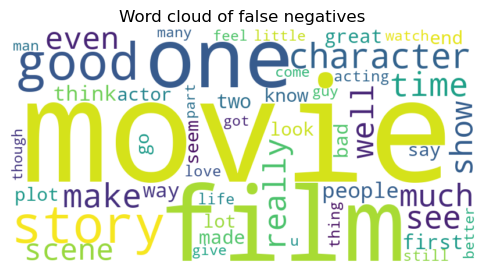

In [206]:
# Word cloud of false negatives
falseNegWords = [''.join(x) for x in falseNegWord.text]
falseNegWords = " ".join(falseNegWords)

falseNegWordcloud = WordCloud(width=800, height=400,
                              background_color='white', max_words=50).generate(falseNegWords)

# Plot the word cloud
plt.figure(figsize=(6, 4.5))
plt.title("Word cloud of false negatives")
plt.imshow(falseNegWordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [207]:
# Dataframe of false negatives
falsePosWord = x_test_complete.query(
    "sentiment == 0 and pred_sentiment == 1")
falsePosWord.head()

,text,sentiment,pred_sentiment,pred_rating,id,rating
28747,watched receiving dvd christmas came pan readi...,0,1,0.966513,26064,4
48076,caught rain people turner classic movie late o...,0,1,0.994075,40969,4
38093,playing showtime right going released movie ca...,0,1,0.827946,43481,1
40576,sure folk made movie think something wonderful...,0,1,0.932074,41554,3
42642,good earth great film mean way ordinary maybe ...,0,1,0.992728,33477,3


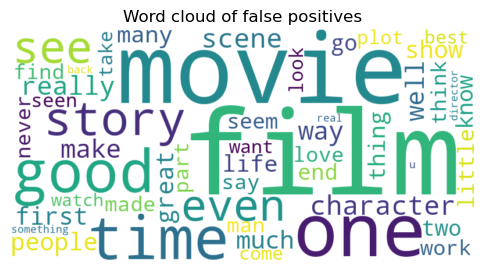

In [208]:
# Word cloud of false positives
falsePosWords = [''.join(x) for x in falsePosWord.text]
falsePosWords = " ".join(falsePosWords)

falsePosWordcloud = WordCloud(width=800, height=400,
                              background_color='white', max_words=50).generate(falsePosWords)

# Plot the word cloud
plt.figure(figsize=(6, 4.5))
plt.title("Word cloud of false positives")
plt.imshow(falsePosWordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

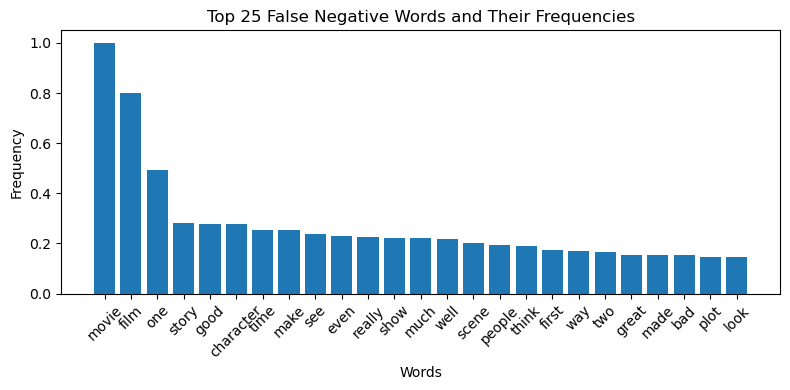

In [218]:
# Extract words and frequencies# Extract the top 25 false negative words
top_25_falseNegWords = sorted(falseNegWordcloud.words_.items(),
                              key=lambda x: x[1], reverse=True)[:25]
words = [word[0] for word in top_25_falseNegWords]
frequencies = [word[1] for word in top_25_falseNegWords]

# Plot the labeled plot
plt.figure(figsize=(8, 4))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 False Negative Words and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

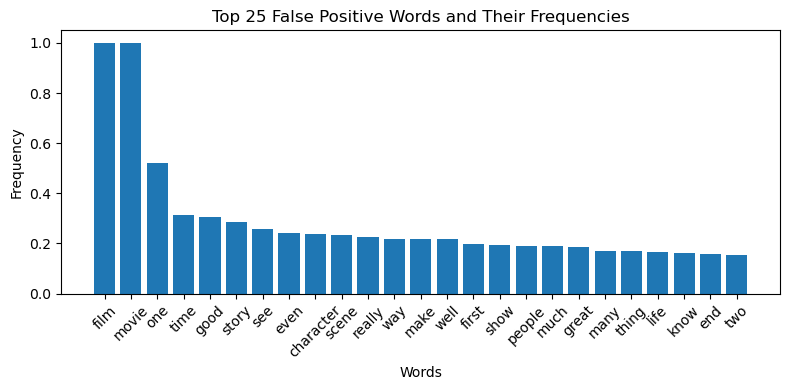

In [217]:
# Extract the top 25 false positive words
top_25_falsePosWords = sorted(falsePosWordcloud.words_.items(),
                              key=lambda x: x[1], reverse=True)[:25]
words = [word[0] for word in top_25_falsePosWords]
frequencies = [word[1] for word in top_25_falsePosWords]

# Plot the labeled plot
plt.figure(figsize=(8, 4))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 25 False Positive Words and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

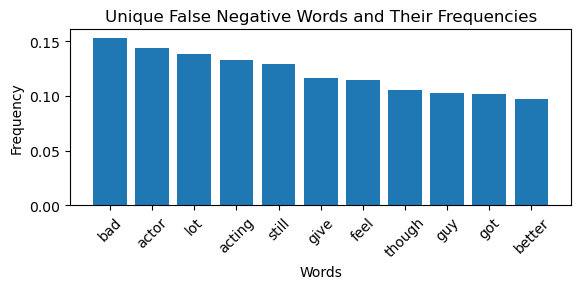

In [234]:
falseNegKey = set(falseNegWordcloud.words_.keys()) - \
    set(falsePosWordcloud.words_.keys())
falseNegItems = {key: falseNegWordcloud.words_.get(key) for key in falseNegKey}
falseNegItems = sorted(falseNegItems.items(),
                       key=lambda x: x[1], reverse=True)
words = [word[0] for word in falseNegItems]
frequencies = [word[1] for word in falseNegItems]

# Plot the labeled plot
plt.figure(figsize=(6, 3))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Unique False Negative Words and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the frequency of words found in false negative text and not in false positive text, we can see that some of these words have a negative connotation to it.


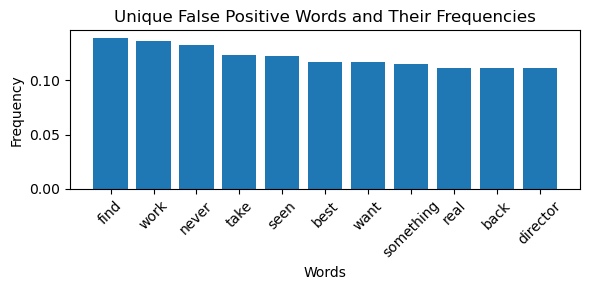

In [233]:
falsePosKey = set(falsePosWordcloud.words_.keys()) - \
    set(falseNegWordcloud.words_.keys())
falsePosItems = {key: falsePosWordcloud.words_.get(key) for key in falsePosKey}
falsePosItems = sorted(falsePosItems.items(),
                       key=lambda x: x[1], reverse=True)
words = [word[0] for word in falsePosItems]
frequencies = [word[1] for word in falsePosItems]

# Plot the labeled plot
plt.figure(figsize=(6, 3))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Unique False Positive Words and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Similarly, the frequency of words found in false positive text and not in false positive text, have some words that have a positive connotation to it.


# Movies Sentiment (Naive Bayes)


## Data processing


### Load libraries


In [2]:
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import warnings
# keras and sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# natural language processing toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("Current working directory: ", os.getcwd())
wd = os.getcwd()
# If current working directory is incorrect, use os.chdir("path")
# Edit the name of the data file from "Movie Review" into "MovieReview"
# and should be contained in the current working directory

Current working directory:  /Users/swislar/Desktop/IT1244/Project


[nltk_data] Downloading package punkt to /Users/swislar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/swislar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing data and data cleaning


Functions for loading and cleaning data


In [ ]:
def filterWords(TEXT):
    '''
    TEXT: String of the sentence
    RETURN: Text clean of HTML tags
    '''
    # Remove HTML Tags
    clean = BeautifulSoup(TEXT, "html.parser").get_text()
    return str(clean)


def loadAllData_nb(WD=os.getcwd()):
    '''
    WD: Current working directory containing datasets- os.getcwd() 
    RETURN: Pandas Dataframe
    '''
    # Initialise the dataframe
    columns = ["id", "rating", "sentiment", "text"]
    rows = []
    posWD = os.path.join(WD, "MovieReview/data/pos")
    negWD = os.path.join(WD, "MovieReview/data/neg")
    # Read positively classified text
    for filename in tqdm(os.listdir(posWD), desc='Processing Positive Reviews'):
        with open(os.path.join(posWD, filename), "r") as file:
            posText = filterWords(file.read())
        # Strip .txt from filename and split ID and Rating as an integer
        posDetails = filename.rstrip(".txt").split("_")
        posID, posRating = int(posDetails[0]), int(posDetails[1])
        # Add data into the Dataframe
        row = {"id": posID, "rating": posRating,
               "sentiment": 1, "text": posText}
        rows.append(row)
    # Repeat for negative text
    for filename in tqdm(os.listdir(negWD), desc='Processing Negative Reviews'):
        with open(os.path.join(negWD, filename), "r") as file:
            negText = filterWords(file.read())
        negDetails = filename.rstrip(".txt").split("_")
        # Offset id by 25000 to prevent overlaps
        negID, negRating = int(negDetails[0]) + 25000, int(negDetails[1])
        row = {"id": negID, "rating": negRating,
               "sentiment": 0, "text": negText}
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)

In [ ]:
dataframe_nb = loadAllData_nb()
dataframe_nb.head(5)

Processing Positive Reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

Processing Positive Reviews:   2%|▏         | 445/25000 [00:00<00:05, 4447.02it/s]/Users/swislar/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
Processing Negative Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4982.05it/s]


,id,rating,sentiment,text
0,20935,9,1,"I just watched ""return from lonesome dove"" and..."
1,12390,8,1,This movie looked like a classic in the cheesy...
2,9820,8,1,Jay Chou plays an orphan raised in a kung fu s...
3,883,7,1,"Ooverall, the movie was fairly good, a good ac..."
4,9063,8,1,"This movie is fun to watch. If you liked ""Dave..."


### Split training and testing data sets


Split the data equally into the training set (80%) and the testing set (20%)


In [ ]:
# Divide positive and negative reviews into test and train sets
df_pos = dataframe_nb[dataframe_nb['rating'] >= 5]
df_neg = dataframe_nb[dataframe_nb['rating'] < 5]
print(f'Shape of df_pos is {df_pos.shape}')
print(f'Shape of df_neg is {df_neg.shape}\n')
# Shuffle the data into its group
df_pos = shuffle(df_pos, random_state=321)
df_neg = shuffle(df_neg, random_state=123)
# Training(0.7) and test(0.2) for the pos set
x_pos = df_pos['text']
y_pos = df_pos['sentiment']
x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(
    x_pos, y_pos, test_size=0.2, random_state=99)
# Training(0.8) and test(0.2) for the neg set
x_neg = df_neg['text']
y_neg = df_neg['sentiment']
x_train_neg, x_test_neg, y_train_neg, y_test_neg = train_test_split(
    x_neg, y_neg, test_size=0.2, random_state=99)
# Join the pos and neg sets together and shuffle them
x_train = pd.concat([x_train_pos, x_train_neg], axis=0)
x_test = pd.concat([x_test_pos, x_test_neg], axis=0)
y_train = pd.concat([y_train_pos, y_train_neg], axis=0)
y_test = pd.concat([y_test_pos, y_test_neg], axis=0)
# Check if data is correctly split
print(f'Shape of x_train is {x_train.shape}')
print(f'Shape of x_test is {x_test.shape}\n')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of df_pos is (25000, 4)
Shape of df_neg is (25000, 4)

Shape of x_train is (40000,)
Shape of x_test is (10000,)

Shape of y_train is (40000,)
Shape of y_test is (10000,)


## Model


We vectorize the text which converts each text into a sparse matrix representation of the TF-IDF features and fit into the naive bayes model


In [8]:
vectorizer = TfidfVectorizer()
# Fit and transform the training data
x_train_vect = vectorizer.fit_transform(x_train)
# Transform the testing data
x_test_vect = vectorizer.transform(x_test)

# Initialize and train a Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train_vect, y_train)

# Predict on the testing data
y_pred = nb_classifier.predict(x_test_vect)

# Accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8593


After fitting the naive bayes model, we are able to obtain an accuracy of 85.93%


### Analysis of model


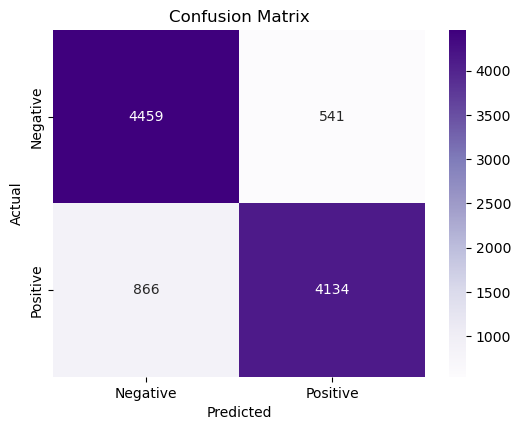

In [9]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4.5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15, 5))
# Update

From the confusion matrix, we can visualise the number true positives and negatives (top left and bottom right) to the number of false positives and negatives (bottom left and top right)


## References


1. Murthy, G. S. N., Allu, S. R., Andhavarapu, B., Bagadi, M., & Belusonti, M. (2020). Text based sentiment analysis using LSTM. Int. J. Eng. Res. Tech. Res, 9(05). </br>
   https://pdfs.semanticscholar.org/0027/d572e43d0c120d59e81c228f2a17b3b05006.pdf
